# MEM-EKF*

Implementation of the MEM-EKF* algorithm according to section 3.2.

This notebooks contains a simple example, to which the MEM-EKF* algorithm will be applied. The example consists of a single stationary, rectangular object. Measurements are generated from the entire object surface.

The notebook aims to provide a simple overview. It is split into data generation and algorithm application.

In [1]:
# import packages
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools

# --- Matplotlib settings:
plt.rc('legend', fontsize=10, handlelength=2)  # legend size
plt.rc('font', size=12)  # fontsize

# colors:
c_gt = 'g'  # color for ground truth
c_meas = 'purple'  # color for measurements
c_est = 'b'  # color for estimates

---
## Data generation
The simple example used here is a stationary, rectangular object where measurements only stem from the object contour.

In this part, data for this model will be generated and visualized.

First of all, the parameters for the object and measurements need to be set:

In [2]:
# --- object: 
object_center_x = 0
object_center_y = 0
object_length = 3  # x axis
object_width = 2 # y axis
# --- concatenate into a single variable x representing the true object location
gt_x = np.array([object_center_x, object_center_y, object_length, object_width])  # essentially an alias for the four parameters

# --- measurements:
# mean number of detections y from the object in each step 
lambda_y = 30
# each true measurement source y will be a 2D vector containing x- and y-position
# covariance of p(z|y) = N(z; y, R)
R = np.eye(2)*0.1

# --- ensure format of parameters is correct
assert R.shape == (2,2), "R needs to be of shape (2,2)"

# --- set up global constants for implementation
N_STEPS = 10  # how many steps to run the simulation for
RNG = default_rng(42)  # numpy random generator 

---
Next, the corresponding measurements will be created, by first sampling a measurement source on the object contour and afterwards adding gaussian noise to generate the measurements passed to the MEM-EKF* algorithm.

In [3]:
def random_rect_surface(center_x, center_y, length, width, n_pts):
    """
    Given center, length and width of an axis-aligned rectangle, generate n_pts many points from its surface without noise.
    Creates two arrays of length n_pts: One with random x-coordinates in the rectangle, and a second one with random y-Coordinates.
    """
    xs = RNG.uniform(low=center_x - length / 2, high=center_x + length / 2, size=n_pts)
    ys = RNG.uniform(low=center_y - width / 2, high=center_y + width / 2, size=n_pts)
    return np.array(xs), np.array(ys)

# ---
# Use the above function to generate measurements:
# ---
    
y = []  # measurement sources
z = []  # received measurements
# use the above function to draw the corresponding measurements
for i in range(N_STEPS):
    n_measurements = RNG.poisson(lam=lambda_y)  # number of sources is poisson distributed with mean as specified above
    y_pos_x, y_pos_y = random_rect_surface(object_center_x, object_center_y, object_length, object_width, n_pts=n_measurements)  # get measurement source
    
    y_i = np.vstack([y_pos_x, y_pos_y]).T  #  current measurement sources to y, in shape (n_measurements, 2)
    y.append(y_i)
    # second: draw measurements z_i from y_i
    z_i = []
    for y_i_k in y_i:  # treat each measurement k = 0...n_measurements-1 independently
        z_i_k = RNG.multivariate_normal(mean=y_i_k, cov=R)  # p(z|y) = N(z; y, R)
        z_i.append(z_i_k)
    z_i = np.array(z_i)
    assert z_i.shape == y_i.shape, "Mismatch between z and y shape"
    z.append(z_i)
    
    print("Step: {}/{} - Number of Measurements generated: {}".format(i+1, N_STEPS, n_measurements))

Step: 1/10 - Number of Measurements generated: 35
Step: 2/10 - Number of Measurements generated: 41
Step: 3/10 - Number of Measurements generated: 28
Step: 4/10 - Number of Measurements generated: 40
Step: 5/10 - Number of Measurements generated: 33
Step: 6/10 - Number of Measurements generated: 33
Step: 7/10 - Number of Measurements generated: 28
Step: 8/10 - Number of Measurements generated: 27
Step: 9/10 - Number of Measurements generated: 37
Step: 10/10 - Number of Measurements generated: 22


---
#### Visualize Measurements
Define some necessary functions for plotting and then plot each time step individually.

In [4]:
def plt_square(loc, l, ax=None, label_as_m=True):
    """
    Helper function to quickly focus a plot on a location loc with margins l to all sides.
    Can either pass an axis object, or uses the current axis (plt.gca())
    By default also sets axis labeling to 'x[m]' and 'y[m]'
    """
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(loc[0] - l, loc[0] + l)
    ax.set_ylim(loc[1] - l, loc[1] + l)
    ax.set_aspect('equal', adjustable='box')
    
    if label_as_m:
        ax.set_xlabel("x[m]")
        ax.set_ylabel("y[m]")

fig, all_ax = plt.subplots(nrows=int(N_STEPS / 2), ncols=2, figsize=(11, 5.5*int(N_STEPS/2)))
plt.subplots_adjust(hspace=0.3)
for i in range(N_STEPS):
    row = int(i/2)  # row for plots
    col = i % 2  # col for plots
    ax = all_ax[row][col]
    patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor='g', facecolor='none', label="Object Contour")
    ax.add_patch(patch_ground_truth)
    ax.set_title("Step {}".format(i+1))
    ax.scatter(y[i][:, 0], y[i][:, 1], c=c_gt, label="Measurement sources", alpha=0.5)
    ax.scatter(z[i][:, 0], z[i][:, 1], c=c_meas, label="Measurements")
    
    plt_square(gt_x[:2], 4, ax)
    
    if i == 0:
        ax.legend()
plt.suptitle("Object location, measurement sources and measurements in all time steps")
plt.show()

---
## MEM-EKF*

In this section, the MEM-EKF* algorithm will be applied to the example data generated above.

For the predict step, a small value will be added to the variance of the semi-axis length shape parameters.

---

First, the relevant variables and helper-functions will be defined:

In [146]:
# --- DEFINE VARIABLES
dim_m = 3  # dimension of the kinematic state: 3 (x,y,speed) 
H = np.hstack([np.eye(2), np.zeros((2, dim_m-2))])

# covariance of multiplicative gaussian noise h
z_h_noise = 1/3
C_h = z_h_noise * np.eye(2,2)

In [147]:
# --- DEFINE AUXILIARY FUNCTIONS

def Rot(alpha):
    """
    Constructs a rotation matrix for given angle alpha.
    """
    r = np.array([
        [np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha), np.cos(alpha)]
    ])
    return r

def vect(M):
    """
    From original MEM-EKF* paper:
    Constructs a column vector from a matrix M by stacking its column vectors    
    """
    v = M.flatten(order="F")  # just use ndarray.flatten(), pass `order='F'` for column-major order
    v = np.reshape(v, (len(v), 1))  # ensure output is column vector
    return v

---
Given the above definitions, the `update` function can be implemented as shown in Table III.

Furthermore, the simple `predict` function will be implemented.

In [148]:
# --- DEFINE UPDATE for MEM-EKF*

def update_memekf(z, m_minus, p_minus, C_m_minus, C_p_minus):
    """
    Update function for the MEM-EKF* algorithm as described in Table III.
    Takes a single measurement z as well as the prior estimates for m, p, C^m and C^p as parameters.
    Returns the updated estimates for m, p, C^m and C^p after incorporating z.
    """
    # unpack p_minus
    alpha_minus, l1_minus, l2_minus = p_minus
    
    # F
    F = np.array([
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0]
    ])
    # F tilde
    Ft = np.array([
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]
    ])
    
    S = Rot(alpha_minus[0]) @ np.diag([l1_minus[0], l2_minus[0]])
    S_1 = S[0, :].reshape((1,2))
    S_2 = S[1, :].reshape((1,2))
    
    J_1 = np.block([
        [-1 * l1_minus * np.sin(alpha_minus), np.cos(alpha_minus), 0],
        [-1 * l2_minus * np.cos(alpha_minus), 0, -1 * np.sin(alpha_minus)]
    ])
    J_2 = np.block([
        [l1_minus * np.cos(alpha_minus), np.sin(alpha_minus), 0],
        [-1 * l2_minus * np.sin(alpha_minus), 0, np.cos(alpha_minus)]
    ])
    J = [J_1, J_2]
    
    C_I = S @ C_h @ S.T
    C_II = np.block([
        [np.trace(C_p_minus @ J[m].T @ C_h @ J[n]) for m in range(2)] for n in range(2)
    ]).reshape(2, 2)
    
    M = np.array([
        [2 * S_1 @ C_h @ J_1],
        [2 * S_2 @ C_h @ J_2],
        [S_1 @ C_h @ J_2 + S_2 @ C_h @ J_1]
    ])
    M = np.reshape(M, (3, -1))
    
    C_mz = C_m_minus @ H.T
    C_z = H @ C_m_minus @ H.T + C_I + C_II + R
    Z = F @ np.kron(z - H @ m_minus, z - H @ m_minus)
    Z = np.reshape(Z, (-1, 1))
    Z_bar = F @ vect(C_z)
    
    C_pZ = C_p_minus @ M.T
    C_Z = F @ np.kron(C_z, C_z) @ (F+Ft).T
    
    
    # prepare for final calculations - invert C_z and C_Z
    C_z_inv = np.linalg.inv(C_z)
    C_Z_inv = np.linalg.inv(C_Z)
    p_minus = p_minus.reshape((-1, 1))
    
    # finally: calculate m, p, C_m, C_p
    m_plus = m_minus + C_mz @ C_z_inv @ (z - H @ m_minus)
    C_m_plus = C_m_minus - C_mz @ C_z_inv @ C_mz.T 
    p_plus = p_minus + C_pZ @ C_Z_inv @ (Z - Z_bar)
    C_p_plus = C_p_minus - C_pZ @ C_Z_inv @ C_pZ.T
    
    # enforce symmetry of covariance:
    #     in some scenarios it may be useful to ensure that C^p and C^m are symmetric
    #     the following (optional) two lines enforce the symmetry before returing the matrices
    #     in this simple scenario, this is not necessary 
    C_p_plus = (C_p_plus + C_p_plus.T) * 0.5
    C_m_plus = (C_m_plus + C_m_plus.T) * 0.5
    return m_plus, p_plus, C_m_plus, C_p_plus

def predict_memekf(m_minus, p_minus, C_m_minus, C_p_minus):
    """
    Very simple predict function for mem_ekf. Does not apply any motion model, only slightly increases covariance of Cm and Cp
    """
    m_plus = m_minus
    p_plus = p_minus
    C_m_plus = C_m_minus + np.diag([0, 0, 0])  # no change to kinematic state covariance: we care mostly for the shape in this example
    # a fixed value will be added to the diagonal of the covariance matrix, excluding the orientation (since we assume it to be fixed)
    # this value should be small, and be chosen according to the number of measurements received per step
    # the more measurements are received per step, the smaller this value should be
    k = 0.001  
    C_p_plus = C_p_minus + np.diag([0, k, k])
    return m_plus, p_plus, C_m_plus, C_p_plus

--- 

### MEM-EKF* tracking

With all necessary functions defined, the algorithm can now be applied to the data.

Again, some helper-functions for visualization need to be defined first.

In [149]:
# DEFINE UTILITY FUNCTIONS FOR VISUALIZATION

def pol2cart(rho, phi):
    """
    Help function to convert from polar(radius rho, angle phi) to cartesian coordinates.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
    
def plot_extent(m, p, ax=None):
    """
    Plot the estimated extent of an object described by kinematic state m and extent state p according to the MEM-EKF* definition.
    """
    if ax is None:
        ax = plt.gca()
    alpha, l1, l2 = p
    alpha = np.rad2deg(alpha)
    # l1 and l2 are semi-axis length, so double when passing to patches.Ellipse
    # patches.Ellipse takes angle counter-clockwise
    el = patches.Ellipse(xy = m[:2], width=2*l1, height=2*l2, angle=alpha, fill=False, color=c_est, label="Extent Estimate")
    ax.scatter(m[0], m[1], c=c_est, marker='x')
    ax.add_patch(el)

---
The parameter initialization is important for the algorithm. If the initial shape covariance is too large in comparison to the initial shape mean, the estimate might not behave as expected.

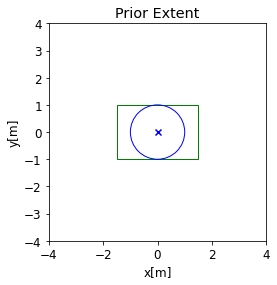

In [150]:
# basis points p with covariance C_p
# state m with covariance C_m
m_init = np.array([0, 0, 0])  # position 0,0 and velocity 0 too
C_m_init = np.eye(3)*0.01
p_init = np.array([0, 1, 1])  # start with a circle
C_p_init = np.diag([0.001, 0.05, 0.05])  # low noise on orientation, higher noise on axis-length

# Take a look at the prior
plt.title("Prior Extent")
patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor=c_gt, facecolor='none')
plt.gca().add_patch(patch_ground_truth)
plot_extent(m_init, p_init)
plt_square(gt_x[:2], 4)
plt.show()

In [151]:
# Arrays to store intermediate results:
m_list = []
Cm_list = []
p_list = []
Cp_list = []

# Initial values:
m = m_init
C_m = C_m_init
p = p_init  # start with a circle
C_p = C_p_init

p = np.reshape(p, (len(p), -1))
for i in range(N_STEPS):
    # get measurements z_i for this step
    z_i = z[i]
    m, p, C_m, C_p = predict_memekf(m, p, C_m, C_p)  # time update - once per time step
    # measurement update: individually for each single measurement from this time step
    for z_i_k in z_i:  
        m, p, C_m, C_p = update_memekf(z_i_k, m, p, C_m, C_p)  # update with new measurement
    m_list.append(m)
    Cm_list.append(C_m)
    p_list.append(p)
    Cp_list.append(C_p)

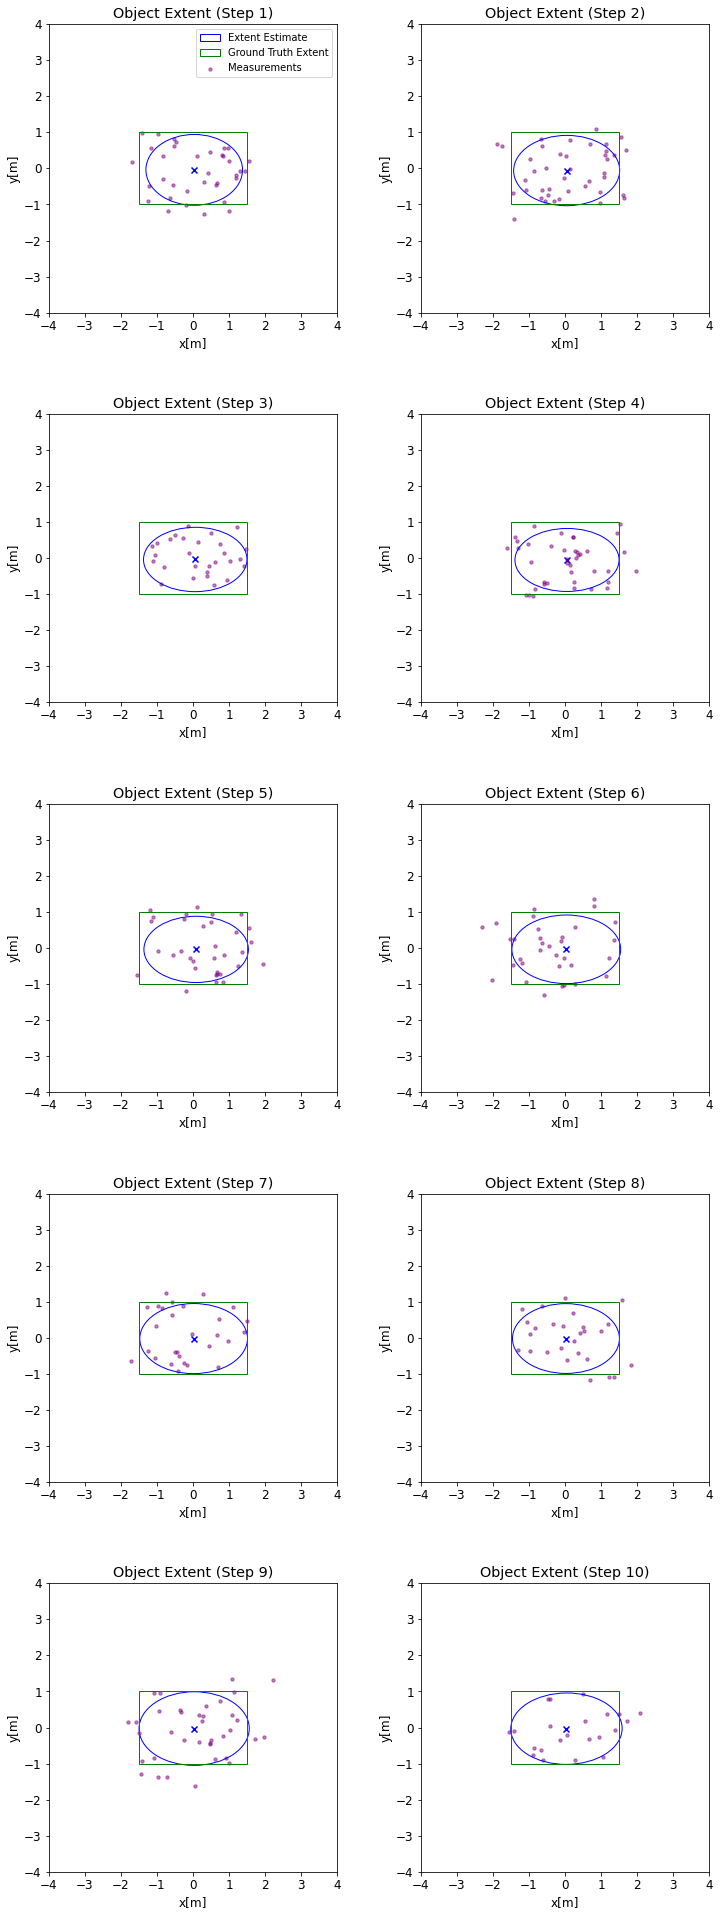

In [152]:
# Visualize each step indivdually:
SIZE = 4  # size parameter for subplots
fig, all_ax = plt.subplots(nrows=int(N_STEPS / 2), ncols=2, figsize=(11, 5.5*int(N_STEPS/2)))
fig.tight_layout(pad=4.0)
plt.subplots_adjust(hspace=0.3)
for i in range(N_STEPS):
    row = int(i/2)  # row for plots
    col = i % 2  # col for plots
    ax = all_ax[row][col]
    # --- EXTENT ESTIMATE:
    plt.sca(ax)
    plot_extent(m_list[i], p_list[i])
    
    # add ground truth:
    patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor=c_gt, facecolor='none', label="Ground Truth Extent")
    ax.add_patch(patch_ground_truth)
    
    # add measurements 
    ax.scatter(z[i][:, 0], z[i][:, 1], c=c_meas, label="Measurements", alpha=0.5, s=11)
    
    # add title and formatting:
    ax.set_title("Object Extent (Step {})".format(i+1))
    plt_square(gt_x[:2], 4)

    if i == 0:
        ax.legend()
plt.show()